In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from utils_fashion import fashion_mnist, plot_graphs, plot_fashion_mnist
import numpy as np

In [2]:
train_loader, valid_loader, test_loader = fashion_mnist(valid=10000)

In [3]:
class Net (nn.Module):
    def __init__ (self, batchnorm = False, dropout = False, lr=1e-4, l2 = 0.0):
        super (Net, self).__init__ ()
        self.fc1 = nn.Linear (28 * 28, 64)
        self.fc2 = nn.Linear (64, 64)
        self.fc3 = nn.Linear (64, 10)
        self.batchnorm = batchnorm
        if self.batchnorm:
            self.bn = nn.BatchNorm1d (512)
        self.dropout = dropout
        self.optim = optim.Adam (self.parameters (), lr = lr, weight_decay = l2)
        
    def forward (self, x):
        x = x.view (-1, 28 * 28)
        x = torch.tanh (self.fc1 (x))
        x = torch.tanh (self.fc2 (x))
        x = torch.log_softmax (self.fc3 (x), dim = 1)
        return x
    
    def loss (self, output, target, **kwargs):
        self._loss = F.nll_loss (output, target, **kwargs)
        return self._loss

In [4]:
def train(epoch, models):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)

In [5]:
models = {'default': Net(False, False)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [6]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [7]:
for epoch in range(1, 101):
    for model in models.values():
        model.train()
    train(epoch, models)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)
    test(models, train_loader, train_log)

Train Epoch: 1 [0/50000 (0%)]	Losses default: 2.259680
Train Epoch: 1 [10000/50000 (20%)]	Losses default: 1.100416
Train Epoch: 1 [20000/50000 (40%)]	Losses default: 0.786828
Train Epoch: 1 [30000/50000 (60%)]	Losses default: 0.720128
Train Epoch: 1 [40000/50000 (80%)]	Losses default: 0.520200
Train Epoch: 1 [50000/50000 (100%)]	Losses default: 0.637889
Test set:
default: Loss: 0.5610	Accuracy: 8214.0/10000 (82%)

Test set:
default: Loss: 0.5575	Accuracy: 41056.0/50000 (82%)

Train Epoch: 2 [0/50000 (0%)]	Losses default: 0.557460
Train Epoch: 2 [10000/50000 (20%)]	Losses default: 0.571239
Train Epoch: 2 [20000/50000 (40%)]	Losses default: 0.466806
Train Epoch: 2 [30000/50000 (60%)]	Losses default: 0.677013
Train Epoch: 2 [40000/50000 (80%)]	Losses default: 0.733523
Train Epoch: 2 [50000/50000 (100%)]	Losses default: 0.472284
Test set:
default: Loss: 0.4558	Accuracy: 8406.0/10000 (84%)

Test set:
default: Loss: 0.4439	Accuracy: 42348.0/50000 (85%)

Train Epoch: 3 [0/50000 (0%)]	Losses d

Train Epoch: 18 [10000/50000 (20%)]	Losses default: 0.190561
Train Epoch: 18 [20000/50000 (40%)]	Losses default: 0.229029
Train Epoch: 18 [30000/50000 (60%)]	Losses default: 0.149806
Train Epoch: 18 [40000/50000 (80%)]	Losses default: 0.238925
Train Epoch: 18 [50000/50000 (100%)]	Losses default: 0.275685
Test set:
default: Loss: 0.3209	Accuracy: 8825.0/10000 (88%)

Test set:
default: Loss: 0.2488	Accuracy: 45623.0/50000 (91%)

Train Epoch: 19 [0/50000 (0%)]	Losses default: 0.198964
Train Epoch: 19 [10000/50000 (20%)]	Losses default: 0.075486
Train Epoch: 19 [20000/50000 (40%)]	Losses default: 0.138678
Train Epoch: 19 [30000/50000 (60%)]	Losses default: 0.128634
Train Epoch: 19 [40000/50000 (80%)]	Losses default: 0.195578
Train Epoch: 19 [50000/50000 (100%)]	Losses default: 0.265817
Test set:
default: Loss: 0.3234	Accuracy: 8832.0/10000 (88%)

Test set:
default: Loss: 0.2481	Accuracy: 45600.0/50000 (91%)

Train Epoch: 20 [0/50000 (0%)]	Losses default: 0.424925
Train Epoch: 20 [10000/500

Train Epoch: 35 [10000/50000 (20%)]	Losses default: 0.217937
Train Epoch: 35 [20000/50000 (40%)]	Losses default: 0.165832
Train Epoch: 35 [30000/50000 (60%)]	Losses default: 0.164122
Train Epoch: 35 [40000/50000 (80%)]	Losses default: 0.322117
Train Epoch: 35 [50000/50000 (100%)]	Losses default: 0.232965
Test set:
default: Loss: 0.3253	Accuracy: 8858.0/10000 (89%)

Test set:
default: Loss: 0.1855	Accuracy: 46839.0/50000 (94%)

Train Epoch: 36 [0/50000 (0%)]	Losses default: 0.104311
Train Epoch: 36 [10000/50000 (20%)]	Losses default: 0.142689
Train Epoch: 36 [20000/50000 (40%)]	Losses default: 0.158186
Train Epoch: 36 [30000/50000 (60%)]	Losses default: 0.194964
Train Epoch: 36 [40000/50000 (80%)]	Losses default: 0.173688
Train Epoch: 36 [50000/50000 (100%)]	Losses default: 0.561859
Test set:
default: Loss: 0.3216	Accuracy: 8874.0/10000 (89%)

Test set:
default: Loss: 0.1819	Accuracy: 46828.0/50000 (94%)

Train Epoch: 37 [0/50000 (0%)]	Losses default: 0.260230
Train Epoch: 37 [10000/500

Train Epoch: 52 [10000/50000 (20%)]	Losses default: 0.164428
Train Epoch: 52 [20000/50000 (40%)]	Losses default: 0.080927
Train Epoch: 52 [30000/50000 (60%)]	Losses default: 0.138743
Train Epoch: 52 [40000/50000 (80%)]	Losses default: 0.118798
Train Epoch: 52 [50000/50000 (100%)]	Losses default: 0.155176
Test set:
default: Loss: 0.3465	Accuracy: 8832.0/10000 (88%)

Test set:
default: Loss: 0.1400	Accuracy: 47664.0/50000 (95%)

Train Epoch: 53 [0/50000 (0%)]	Losses default: 0.225192
Train Epoch: 53 [10000/50000 (20%)]	Losses default: 0.098814
Train Epoch: 53 [20000/50000 (40%)]	Losses default: 0.143799
Train Epoch: 53 [30000/50000 (60%)]	Losses default: 0.182794
Train Epoch: 53 [40000/50000 (80%)]	Losses default: 0.130021
Train Epoch: 53 [50000/50000 (100%)]	Losses default: 0.072413
Test set:
default: Loss: 0.3527	Accuracy: 8824.0/10000 (88%)

Test set:
default: Loss: 0.1413	Accuracy: 47603.0/50000 (95%)

Train Epoch: 54 [0/50000 (0%)]	Losses default: 0.079168
Train Epoch: 54 [10000/500

Train Epoch: 69 [10000/50000 (20%)]	Losses default: 0.085816
Train Epoch: 69 [20000/50000 (40%)]	Losses default: 0.101648
Train Epoch: 69 [30000/50000 (60%)]	Losses default: 0.067668
Train Epoch: 69 [40000/50000 (80%)]	Losses default: 0.129613
Train Epoch: 69 [50000/50000 (100%)]	Losses default: 0.106619
Test set:
default: Loss: 0.3863	Accuracy: 8834.0/10000 (88%)

Test set:
default: Loss: 0.1071	Accuracy: 48309.0/50000 (97%)

Train Epoch: 70 [0/50000 (0%)]	Losses default: 0.165880
Train Epoch: 70 [10000/50000 (20%)]	Losses default: 0.057756
Train Epoch: 70 [20000/50000 (40%)]	Losses default: 0.077012
Train Epoch: 70 [30000/50000 (60%)]	Losses default: 0.118888
Train Epoch: 70 [40000/50000 (80%)]	Losses default: 0.103857
Train Epoch: 70 [50000/50000 (100%)]	Losses default: 0.127191
Test set:
default: Loss: 0.3900	Accuracy: 8835.0/10000 (88%)

Test set:
default: Loss: 0.1061	Accuracy: 48275.0/50000 (97%)

Train Epoch: 71 [0/50000 (0%)]	Losses default: 0.073439
Train Epoch: 71 [10000/500

Train Epoch: 86 [10000/50000 (20%)]	Losses default: 0.074503
Train Epoch: 86 [20000/50000 (40%)]	Losses default: 0.165216
Train Epoch: 86 [30000/50000 (60%)]	Losses default: 0.113860
Train Epoch: 86 [40000/50000 (80%)]	Losses default: 0.103896
Train Epoch: 86 [50000/50000 (100%)]	Losses default: 0.068532
Test set:
default: Loss: 0.4432	Accuracy: 8789.0/10000 (88%)

Test set:
default: Loss: 0.0867	Accuracy: 48630.0/50000 (97%)

Train Epoch: 87 [0/50000 (0%)]	Losses default: 0.054528
Train Epoch: 87 [10000/50000 (20%)]	Losses default: 0.147057
Train Epoch: 87 [20000/50000 (40%)]	Losses default: 0.071736
Train Epoch: 87 [30000/50000 (60%)]	Losses default: 0.087741
Train Epoch: 87 [40000/50000 (80%)]	Losses default: 0.033728
Train Epoch: 87 [50000/50000 (100%)]	Losses default: 0.210817
Test set:
default: Loss: 0.4501	Accuracy: 8796.0/10000 (88%)

Test set:
default: Loss: 0.0867	Accuracy: 48657.0/50000 (97%)

Train Epoch: 88 [0/50000 (0%)]	Losses default: 0.068205
Train Epoch: 88 [10000/500

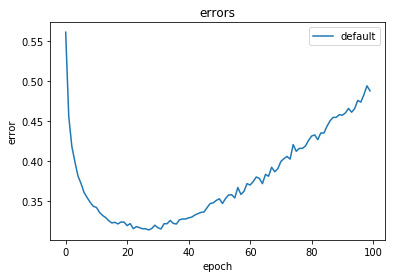

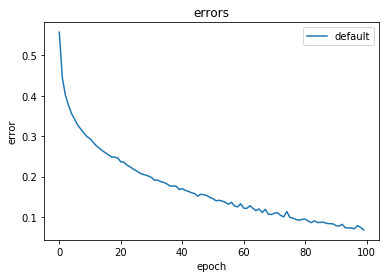

In [8]:
plot_graphs(test_log, 'loss')
plot_graphs(train_log, 'loss')

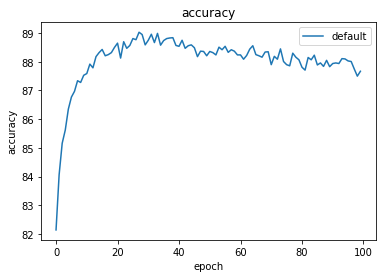

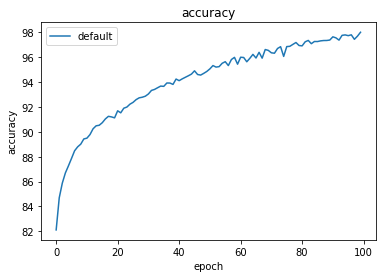

In [9]:
plot_graphs(test_log, 'accuracy')
plot_graphs(train_log, 'accuracy')

In [10]:
test_log

{'default': [(0.5609865779876709, 82.14),
  (0.4558447476387024, 84.06),
  (0.4182097051143646, 85.16),
  (0.39879316711425783, 85.62),
  (0.38103935346603396, 86.35),
  (0.3715824140071869, 86.77),
  (0.3602031931400299, 86.97),
  (0.3538278958797455, 87.34),
  (0.3478672529220581, 87.28),
  (0.34296237268447877, 87.53),
  (0.3416322772026062, 87.59),
  (0.33551022658348084, 87.92),
  (0.33158947677612305, 87.79),
  (0.3289753203392029, 88.18),
  (0.3250182499885559, 88.32),
  (0.32219037432670594, 88.43),
  (0.32294070768356326, 88.21),
  (0.32093233585357667, 88.25),
  (0.3233567501544952, 88.32),
  (0.3231989026069641, 88.5),
  (0.31880367231369017, 88.65),
  (0.3213415930747986, 88.13),
  (0.3150427536010742, 88.7),
  (0.3175740529537201, 88.47),
  (0.3163387746334076, 88.57),
  (0.3148870729923248, 88.81),
  (0.31482043352127076, 88.77),
  (0.3134459463834763, 89.03),
  (0.3151584966421127, 88.95),
  (0.31933119149208067, 88.59),
  (0.3162063430309296, 88.75),
  (0.31460309224128